# Transformer Models for Toxic Comment Classification

This notebook implements and evaluates various transformer architectures (BERT, RoBERTa, DistilBERT) for the toxic comment classification task.

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import torch
import gc
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from torch.optim import AdamW  
import torch.nn.functional as F
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

# Transformers libraries
from transformers import (
    AutoTokenizer, 
    AutoModel,
    AutoModelForSequenceClassification, 
    get_linear_schedule_with_warmup,
    BertTokenizer,
    BertForSequenceClassification,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    DistilBertTokenizer,
    DistilBertForSequenceClassification
)

# Set random seeds
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# ! pip install scikit-multilearn
# 

## 1. Load and Prepare Data

In [3]:
# Load preprocessed data
train_data = pd.read_csv('../Dataset/train_preprocessed.csv')

# Check the data
print(f"Training data shape: {train_data.shape}")
train_data.head()

Training data shape: (159571, 12)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,processed_text,original_length,processed_length,length_reduction
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made my username hardcore me...,264,202,23.484848
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww ! he match background colour im seemingly...,112,86,23.214286
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"hey man , im really not trying edit war . guy ...",233,165,29.184549
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,i cant make real suggestion improvement i wond...,622,406,34.726688
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"you , sir , my hero . chance you remember page...",67,54,19.402985


In [4]:
# Define the features and target labels
X = train_data['comment_text']  # Use the original text
y = train_data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

# Handle missing values
X = X.fillna("")  # Replace NaN values with empty strings
y = y.fillna(0)   # Replace any missing target values with 0



# Convert DataFrame to numpy array for compatibility with iterative_train_test_split
X_array = np.array(X).reshape(len(X), 1)
y_array = y.values

# First split: 90% train+val, 10% test
X_temp_array, y_temp_array, X_test_array, y_test_array = iterative_train_test_split(
    X_array, y_array, test_size=0.1
)

# Second split: Split the 90% into training and validation
X_train_array, y_train_array, X_val_array, y_val_array = iterative_train_test_split(
    X_temp_array, y_temp_array, test_size=0.11
)

# Convert back to pandas format
X_train = pd.Series(X_train_array.flatten())
X_val = pd.Series(X_val_array.flatten())
X_test = pd.Series(X_test_array.flatten())

y_train = pd.DataFrame(y_train_array, columns=y.columns)
y_val = pd.DataFrame(y_val_array, columns=y.columns)
y_test = pd.DataFrame(y_test_array, columns=y.columns)

# Verify the distributions
print("\nTraining set distribution:")
for col in y.columns:
    print(f"{col}: {y_train[col].mean():.4f} ({y_train[col].sum()} samples)")

print("\nValidation set distribution:")
for col in y.columns:
    print(f"{col}: {y_val[col].mean():.4f} ({y_val[col].sum()} samples)")

print("\nTest set distribution:")
for col in y.columns:
    print(f"{col}: {y_test[col].mean():.4f} ({y_test[col].sum()} samples)")


Training set distribution:
toxic: 0.0958 (12251 samples)
severe_toxic: 0.0100 (1278 samples)
obscene: 0.0530 (6768 samples)
threat: 0.0030 (380 samples)
insult: 0.0494 (6309 samples)
identity_hate: 0.0088 (1122 samples)

Validation set distribution:
toxic: 0.0958 (1514 samples)
severe_toxic: 0.0100 (158 samples)
obscene: 0.0529 (836 samples)
threat: 0.0032 (50 samples)
insult: 0.0494 (780 samples)
identity_hate: 0.0088 (139 samples)

Test set distribution:
toxic: 0.0958 (1529 samples)
severe_toxic: 0.0100 (159 samples)
obscene: 0.0530 (845 samples)
threat: 0.0030 (48 samples)
insult: 0.0494 (788 samples)
identity_hate: 0.0090 (144 samples)


In [5]:
# For transformers, create a stratified subsample
SAMPLE_SIZE = 10000

# Convert to numpy arrays for iterative_train_test_split
X_train_arr = np.array(X_train).reshape(-1, 1)
y_train_arr = y_train.values

# Calculate split ratio to get approximately SAMPLE_SIZE examples
sample_ratio = min(SAMPLE_SIZE / len(X_train), 0.99)

# Get stratified sample
X_train_sample_arr, y_train_sample_arr, _, _ = iterative_train_test_split(
    X_train_arr, y_train_arr, test_size=(1-sample_ratio)
)

# Convert back to pandas
X_train = pd.Series(X_train_sample_arr.flatten())
y_train = pd.DataFrame(y_train_sample_arr, columns=y_train.columns)

# Do the same for validation set
X_val_arr = np.array(X_val).reshape(-1, 1)
y_val_arr = y_val.values

val_sample_ratio = min((SAMPLE_SIZE // 5) / len(X_val), 0.99)

X_val_sample_arr, y_val_sample_arr, _, _ = iterative_train_test_split(
    X_val_arr, y_val_arr, test_size=(1-val_sample_ratio)
)

X_val = pd.Series(X_val_sample_arr.flatten())
y_val = pd.DataFrame(y_val_sample_arr, columns=y_val.columns)

# Print the resulting class distributions to verify
print(f"Sampled train size: {len(X_train)}")
print(f"Sampled validation size: {len(X_val)}")

print("\nSampled training set distribution:")
for col in y_train.columns:
    print(f"{col}: {y_train[col].mean():.4f} ({y_train[col].sum()} samples)")

print("\nSampled validation set distribution:")
for col in y_val.columns:
    print(f"{col}: {y_val[col].mean():.4f} ({y_val[col].sum()} samples)")

Sampled train size: 10001
Sampled validation size: 2001

Sampled training set distribution:
toxic: 0.0958 (958 samples)
severe_toxic: 0.0100 (100 samples)
obscene: 0.0530 (530 samples)
threat: 0.0030 (30 samples)
insult: 0.0494 (494 samples)
identity_hate: 0.0088 (88 samples)

Sampled validation set distribution:
toxic: 0.0960 (192 samples)
severe_toxic: 0.0100 (20 samples)
obscene: 0.0530 (106 samples)
threat: 0.0060 (12 samples)
insult: 0.0495 (99 samples)
identity_hate: 0.0090 (18 samples)


In [6]:
def oversample_minority_classes(X_train, y_train):
    """Oversample minority classes to improve balance"""
    
    # Original data
    original_X = X_train.copy()
    original_y = y_train.copy()
    augmented_X = []
    augmented_y = []
    
    # Identify and oversample each rare class with increased multipliers
    multipliers = {
        'threat': 5,
        'identity_hate': 3,
        'severe_toxic': 3
    }
    
    for label, multiplier in multipliers.items():
        pos_indices = y_train[y_train[label] == 1].index
        pos_X = X_train.loc[pos_indices]
        pos_y = y_train.loc[pos_indices]
        
        for _ in range(multiplier - 1):
            augmented_X.append(pos_X)
            augmented_y.append(pos_y)
    
    # Combine with original data
    augmented_X = pd.concat([original_X] + augmented_X)
    augmented_y = pd.concat([original_y] + augmented_y)
    
    return augmented_X.reset_index(drop=True), augmented_y.reset_index(drop=True)

print("Class distribution BEFORE oversampling:")
for col in y_train.columns:
    print(f"{col}: {y_train[col].mean():.4f} ({y_train[col].sum()} samples)")

# Apply augmentation
X_train, y_train = oversample_minority_classes(X_train, y_train)

# Check distribution after oversampling
print("\nClass distribution AFTER oversampling:")
for col in y_train.columns:
    print(f"{col}: {y_train[col].mean():.4f} ({y_train[col].sum()} samples)")


Class distribution BEFORE oversampling:
toxic: 0.0958 (958 samples)
severe_toxic: 0.0100 (100 samples)
obscene: 0.0530 (530 samples)
threat: 0.0030 (30 samples)
insult: 0.0494 (494 samples)
identity_hate: 0.0088 (88 samples)

Class distribution AFTER oversampling:
toxic: 0.1366 (1434 samples)
severe_toxic: 0.0347 (364 samples)
obscene: 0.0915 (960 samples)
threat: 0.0168 (176 samples)
insult: 0.0873 (916 samples)
identity_hate: 0.0316 (332 samples)


## 2. Create Dataset for Transformer Models

In [7]:
class ToxicCommentDatasetTransformer(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        labels = torch.FloatTensor(self.labels.iloc[idx].values)
        
        # Tokenize the text
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Remove the batch dimension added by the tokenizer
        encoding = {k: v.squeeze(0) for k, v in encoding.items()}
        
        # Add labels
        encoding['labels'] = labels
        
        return encoding

## 3. Build Transformer Models

In [31]:
class BertForMultiLabelClassification(nn.Module):
    def __init__(self, num_labels, model_name="bert-base-uncased", dropout_rate=0.1):
        super(BertForMultiLabelClassification, self).__init__()
        self.num_labels = num_labels
        
        # Load pre-trained BERT model
        self.bert = AutoModel.from_pretrained(model_name)
        
        # Classification head
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids=None, labels=None):
        # Check model type to determine if token_type_ids should be used
        if 'distilbert' in self.bert.config._name_or_path or 'roberta' in self.bert.config._name_or_path:
            outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
        else:
            outputs = self.bert(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
        
        # Use the [CLS] token representation
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        # Apply sigmoid activation for multi-label
        return torch.sigmoid(logits)

## 4. Training and Evaluation Functions

In [9]:
# Add the AdaptiveFocalLoss class from your RNN notebook
class AdaptiveFocalLoss(nn.Module):
    def __init__(self, alpha=None, class_gammas=None):
        super().__init__()
        self.alpha = alpha
        self.class_gammas = class_gammas
        self.epsilon = 1e-6
        
    def forward(self, inputs, targets):
        inputs = torch.clamp(inputs, self.epsilon, 1 - self.epsilon)
        
        # Binary cross entropy
        bce_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        
        # Different gamma for each class
        focal_loss = torch.zeros_like(bce_loss)
        class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        
        for i, col in enumerate(class_names):
            gamma = self.class_gammas.get(col, 2.0)  # Default gamma is 2.0
            pt = torch.exp(-bce_loss[:, i])
            focal_weight = (1 - pt) ** gamma
            
            # Apply class weights if provided
            if self.alpha is not None:
                focal_weight = focal_weight * self.alpha[i]
                
            focal_loss[:, i] = focal_weight * bce_loss[:, i]
        
        return focal_loss.mean()

In [10]:
# Calculate class weights based on the training set distribution
class_dist = np.array([y_train[col].mean() for col in y_train.columns])
print(f"Class distribution: {class_dist}")
class_weights = 1 / (class_dist + 0.01)  # Add small epsilon to avoid division by zero
class_weights = class_weights / class_weights.sum() * len(class_weights)  # Normalize weights

# Adjust class weights for rare classes
class_weights[3] *= 30  # Increase weight for threat
class_weights[5] *= 8   # Increase weight for identity_hate
class_weights[1] *= 8   # Increase weight for severe_toxic

print(f"Class weights: {class_weights}")

# Define class-specific gamma values for focal loss
class_gammas = {
    'toxic': 1.0,
    'severe_toxic': 1.5, 
    'obscene': 1.0,
    'threat': 1.5,
    'insult': 1.0,
    'identity_hate': 2.0
}

# Create the focal loss
criterion = AdaptiveFocalLoss(alpha=torch.FloatTensor(class_weights), class_gammas=class_gammas).to(device)


Class distribution: [0.13661046 0.03467657 0.0914547  0.0167667  0.08726303 0.03162808]
Class weights: [ 0.36961066  9.70330242  0.53411807 60.7345678   0.55713656 10.41389051]


In [11]:
def train_transformer_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    epoch_loss = 0
    
    progress_bar = tqdm(data_loader, desc="Training")
    
    for batch in progress_bar:
        optimizer.zero_grad()
        
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        if 'token_type_ids' in batch:
            token_type_ids = batch['token_type_ids'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        else:
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Calculate loss - binary cross entropy for multi-label
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Optimizer and scheduler steps
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
    
    return epoch_loss / len(data_loader)

In [12]:
def evaluate_transformer(model, data_loader, device, threshold=0.5):
    model.eval()
    all_predictions = []
    all_labels = []
    total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            if 'token_type_ids' in batch:
                token_type_ids = batch['token_type_ids'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
            else:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Calculate loss
            loss = nn.BCELoss()(outputs, labels)
            total_loss += loss.item()
            
            # Convert outputs to binary predictions
            preds = (outputs > threshold).float().cpu().numpy()
            true_labels = labels.cpu().numpy()
            
            all_predictions.append(preds)
            all_labels.append(true_labels)
    
    # Concatenate all batches
    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)
    
    # Calculate metrics
    accuracy = accuracy_score(all_labels.flatten(), all_predictions.flatten())
    macro_f1 = f1_score(all_labels, all_predictions, average='macro')
    micro_f1 = f1_score(all_labels, all_predictions, average='micro')
    
    # Calculate per-class F1
    class_f1 = {}
    for i, col in enumerate(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']):
        class_f1[col] = f1_score(all_labels[:, i], all_predictions[:, i])
    
    avg_loss = total_loss / len(data_loader)
    
    return {
        'accuracy': accuracy,
        'macro_f1': macro_f1,
        'micro_f1': micro_f1,
        'class_f1': class_f1,
        'loss': avg_loss,
        'predictions': all_predictions,
        'true_labels': all_labels
    }

In [13]:
def train_transformer_model(model, train_loader, val_loader, optimizer, scheduler, device, 
                           num_epochs=3, patience=2, model_save_path='../models/best_transformer.pt'):
    best_val_loss = float('inf')
    train_losses = []
    val_losses = []
    counter = 0  # For early stopping
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Train
        start_time = time.time()
        train_loss = train_transformer_epoch(model, train_loader, optimizer, scheduler, device)
        train_losses.append(train_loss)
        
        # Validate
        val_results = evaluate_transformer(model, val_loader, device)
        val_loss = val_results['loss']
        val_losses.append(val_loss)
        
        # Print epoch summary
        time_elapsed = time.time() - start_time
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | "
              f"Val F1 Macro: {val_results['macro_f1']:.4f} | "
              f"Time: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
        
        # Print class-wise F1 scores
        print("Class F1 scores:")
        for cls, f1 in val_results['class_f1'].items():
            print(f"  {cls}: {f1:.4f}")
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Saved best model with val_loss: {val_loss:.4f}")
            counter = 0  # Reset early stopping counter
        else:
            counter += 1
            print(f"EarlyStopping counter: {counter} out of {patience}")
            if counter >= patience:
                print("Early stopping triggered")
                break
                
    return train_losses, val_losses

## 5. BERT Implementation

In [16]:
# Initialize BERT tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForMultiLabelClassification(num_labels=6, model_name='bert-base-uncased')
bert_model.to(device)

# Create datasets with the BERT tokenizer
train_dataset = ToxicCommentDatasetTransformer(X_train, y_train, bert_tokenizer)
val_dataset = ToxicCommentDatasetTransformer(X_val, y_val, bert_tokenizer)

# Create dataloaders
BATCH_SIZE = 16  # Smaller batch size for Transformer models due to memory constraints

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

In [17]:
# Setup optimizer and scheduler
optimizer = AdamW(bert_model.parameters(), lr=2e-5)

# Calculate total steps for scheduler
total_steps = len(train_loader) * 3  # 3 epochs
warmup_steps = int(total_steps * 0.1)  # 10% of total steps for warmup

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [18]:
# Train BERT model
os.makedirs('../models', exist_ok=True)
bert_train_losses, bert_val_losses = train_transformer_model(
    bert_model,
    train_loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    num_epochs=3,
    patience=2,
    model_save_path='../models/bert_toxic_classifier.pt'
)

Epoch 1/3


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.3266 | Val Loss: 0.0798 | Val F1 Macro: 0.5949 | Time: 16m 47s
Class F1 scores:
  toxic: 0.7683
  severe_toxic: 0.3500
  obscene: 0.7590
  threat: 0.5000
  insult: 0.6919
  identity_hate: 0.5000
Saved best model with val_loss: 0.0798
Epoch 2/3


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.0289 | Val Loss: 0.0696 | Val F1 Macro: 0.6262 | Time: 16m 45s
Class F1 scores:
  toxic: 0.8021
  severe_toxic: 0.4091
  obscene: 0.7692
  threat: 0.5000
  insult: 0.7604
  identity_hate: 0.5161
Saved best model with val_loss: 0.0696
Epoch 3/3


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.0111 | Val Loss: 0.0659 | Val F1 Macro: 0.6270 | Time: 16m 42s
Class F1 scores:
  toxic: 0.7884
  severe_toxic: 0.4000
  obscene: 0.7767
  threat: 0.5000
  insult: 0.7638
  identity_hate: 0.5333
Saved best model with val_loss: 0.0659


## 6. RoBERTa Implementation

In [20]:
# Initialize RoBERTa tokenizer and model
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
roberta_model = BertForMultiLabelClassification(num_labels=6, model_name='roberta-base')
roberta_model.to(device)

# Create datasets with the RoBERTa tokenizer
train_dataset_roberta = ToxicCommentDatasetTransformer(X_train, y_train, roberta_tokenizer)
val_dataset_roberta = ToxicCommentDatasetTransformer(X_val, y_val, roberta_tokenizer)

# Create dataloaders
train_loader_roberta = DataLoader(
    train_dataset_roberta,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader_roberta = DataLoader(
    val_dataset_roberta,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Setup optimizer and scheduler for RoBERTa
optimizer_roberta = AdamW(roberta_model.parameters(), lr=2e-5)
scheduler_roberta = get_linear_schedule_with_warmup(
    optimizer_roberta,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [22]:
# Train RoBERTa model
roberta_train_losses, roberta_val_losses = train_transformer_model(
    roberta_model,
    train_loader_roberta,
    val_loader_roberta,
    optimizer_roberta,
    scheduler_roberta,
    device,
    num_epochs=3,
    patience=2,
    model_save_path='../models/roberta_toxic_classifier.pt'
)

Epoch 1/3


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.5548 | Val Loss: 0.0740 | Val F1 Macro: 0.6383 | Time: 17m 8s
Class F1 scores:
  toxic: 0.7582
  severe_toxic: 0.5200
  obscene: 0.7767
  threat: 0.5263
  insult: 0.7487
  identity_hate: 0.5000
Saved best model with val_loss: 0.0740
Epoch 2/3


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.0578 | Val Loss: 0.0654 | Val F1 Macro: 0.6230 | Time: 17m 23s
Class F1 scores:
  toxic: 0.7888
  severe_toxic: 0.4400
  obscene: 0.7534
  threat: 0.5714
  insult: 0.7556
  identity_hate: 0.4286
Saved best model with val_loss: 0.0654
Epoch 3/3


Training:   0%|          | 0/657 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/126 [00:00<?, ?it/s]

Train Loss: 0.0143 | Val Loss: 0.0622 | Val F1 Macro: 0.6361 | Time: 17m 17s
Class F1 scores:
  toxic: 0.7828
  severe_toxic: 0.4783
  obscene: 0.7887
  threat: 0.5000
  insult: 0.7668
  identity_hate: 0.5000
Saved best model with val_loss: 0.0622


In [37]:


# Move previous models to CPU
bert_model = bert_model.cpu()
roberta_model = roberta_model.cpu()

# Force garbage collection
gc.collect()
torch.cuda.empty_cache()

# Now load DistilBERT to GPU
distilbert_model = BertForMultiLabelClassification(num_labels=6, model_name='distilbert-base-uncased')
distilbert_model.to(device)

BertForMultiLabelClassification(
  (bert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
          

## 7. DistilBERT Implementation (Faster Training)

In [38]:
# Initialize DistilBERT tokenizer and model
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = BertForMultiLabelClassification(num_labels=6, model_name='distilbert-base-uncased')
distilbert_model.to(device)

# Create datasets with the DistilBERT tokenizer
train_dataset_distilbert = ToxicCommentDatasetTransformer(X_train, y_train, distilbert_tokenizer)
val_dataset_distilbert = ToxicCommentDatasetTransformer(X_val, y_val, distilbert_tokenizer)

# Create dataloaders
train_loader_distilbert = DataLoader(
    train_dataset_distilbert,
    batch_size=BATCH_SIZE * 2,  # Can use larger batch size with DistilBERT
    shuffle=True,
    num_workers=2
)

val_loader_distilbert = DataLoader(
    val_dataset_distilbert,
    batch_size=BATCH_SIZE * 2,
    shuffle=False,
    num_workers=2
)

In [39]:
# Setup optimizer and scheduler for DistilBERT
optimizer_distilbert = AdamW(distilbert_model.parameters(), lr=3e-5)  # Slightly higher learning rate
scheduler_distilbert = get_linear_schedule_with_warmup(
    optimizer_distilbert,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

In [40]:
# Train DistilBERT model (faster training)
distilbert_train_losses, distilbert_val_losses = train_transformer_model(
    distilbert_model,
    train_loader_distilbert,
    val_loader_distilbert,
    optimizer_distilbert,
    scheduler_distilbert,
    device,
    num_epochs=4,  # Can train for more epochs due to faster training
    patience=2,
    model_save_path='../models/distilbert_toxic_classifier.pt'
)

Epoch 1/4


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.4287 | Val Loss: 0.1033 | Val F1 Macro: 0.3787 | Time: 7m 31s
Class F1 scores:
  toxic: 0.4923
  severe_toxic: 0.3810
  obscene: 0.6456
  threat: 0.0000
  insult: 0.5714
  identity_hate: 0.1818
Saved best model with val_loss: 0.1033
Epoch 2/4


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0442 | Val Loss: 0.0754 | Val F1 Macro: 0.6414 | Time: 7m 24s
Class F1 scores:
  toxic: 0.7527
  severe_toxic: 0.4615
  obscene: 0.7487
  threat: 0.7000
  insult: 0.7407
  identity_hate: 0.4444
Saved best model with val_loss: 0.0754
Epoch 3/4


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0157 | Val Loss: 0.0696 | Val F1 Macro: 0.5754 | Time: 7m 30s
Class F1 scores:
  toxic: 0.7781
  severe_toxic: 0.4211
  obscene: 0.7805
  threat: 0.4706
  insult: 0.7292
  identity_hate: 0.2727
Saved best model with val_loss: 0.0696
Epoch 4/4


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Train Loss: 0.0085 | Val Loss: 0.0655 | Val F1 Macro: 0.6383 | Time: 7m 34s
Class F1 scores:
  toxic: 0.7885
  severe_toxic: 0.4500
  obscene: 0.7586
  threat: 0.6316
  insult: 0.7565
  identity_hate: 0.4444
Saved best model with val_loss: 0.0655


## 8. Evaluate on Test Set

In [51]:
# Create test dataset with each tokenizer
test_dataset_bert = ToxicCommentDatasetTransformer(X_test, y_test, bert_tokenizer)
test_dataset_roberta = ToxicCommentDatasetTransformer(X_test, y_test, roberta_tokenizer)
test_dataset_distilbert = ToxicCommentDatasetTransformer(X_test, y_test, distilbert_tokenizer)

# Create test dataloaders
test_loader_bert = DataLoader(test_dataset_bert, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)
test_loader_roberta = DataLoader(test_dataset_roberta, batch_size=BATCH_SIZE, shuffle=False, num_workers=16)
test_loader_distilbert = DataLoader(test_dataset_distilbert, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=16)

In [54]:
def clear_gpu_memory(models_to_cpu=None):
    """
    Thoroughly clears GPU memory and reports memory usage before and after.
    
    Args:
        models_to_cpu: List of PyTorch models to explicitly move to CPU
    """
    # Get initial memory usage
    if torch.cuda.is_available():
        initial_allocated = torch.cuda.memory_allocated() / (1024 ** 3)  # GB
        initial_cached = torch.cuda.memory_reserved() / (1024 ** 3)      # GB
        
        print(f"Before clearing - Allocated: {initial_allocated:.3f} GB, Reserved: {initial_cached:.3f} GB")
        
        # Move specified models to CPU if provided
        if models_to_cpu is not None:
            for i, model in enumerate(models_to_cpu):
                if isinstance(model, torch.nn.Module):
                    print(f"Moving model {i+1}/{len(models_to_cpu)} to CPU...")
                    model.to('cpu')
                    # Delete any model optimizer states
                    if hasattr(model, 'optimizer'):
                        del model.optimizer
        
        # Move all CUDA tensors to CPU that are still in memory
        for obj in gc.get_objects():
            try:
                if torch.is_tensor(obj) and obj.device.type == 'cuda':
                    obj.data = obj.data.cpu()
                    if obj._grad is not None:
                        obj._grad.data = obj._grad.data.cpu()
            except:
                pass
        
        # Force garbage collection
        gc.collect()
        
        # Empty cache to release GPU memory
        torch.cuda.empty_cache()
        
        # Reset peak memory stats
        torch.cuda.reset_peak_memory_stats()
        
        # Report memory after clearing
        final_allocated = torch.cuda.memory_allocated() / (1024 ** 3)
        final_cached = torch.cuda.memory_reserved() / (1024 ** 3)
        print(f"After clearing - Allocated: {final_allocated:.3f} GB, Reserved: {final_cached:.3f} GB")
        print(f"Freed approximately {initial_allocated - final_allocated:.3f} GB")
    else:
        print("CUDA not available - running on CPU")

clear_gpu_memory()

Before clearing - Allocated: 2.524 GB, Reserved: 2.777 GB


/home/sunesh/.local/lib/python3.10/site-packages/torch/__init__.py:1113: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  return isinstance(obj, torch.Tensor)


After clearing - Allocated: 0.016 GB, Reserved: 0.039 GB
Freed approximately 2.508 GB


In [55]:
# Load the best models and ensure they're on the correct device
bert_model.load_state_dict(torch.load('../models/bert_toxic_classifier.pt', map_location=device))
bert_model.to(device)  # Make sure the model is on the right device

roberta_model.load_state_dict(torch.load('../models/roberta_toxic_classifier.pt', map_location=device))
roberta_model.to(device)  # Make sure the model is on the right device

distilbert_model.load_state_dict(torch.load('../models/distilbert_toxic_classifier.pt', map_location=device))
distilbert_model.to(device)  # Make sure the model is on the right device

# Evaluate on test set
print("Evaluating BERT model on test set...")
bert_test_results = evaluate_transformer(bert_model, test_loader_bert, device)

print("\nEvaluating RoBERTa model on test set...")
roberta_test_results = evaluate_transformer(roberta_model, test_loader_roberta, device)

print("\nEvaluating DistilBERT model on test set...")
distilbert_test_results = evaluate_transformer(distilbert_model, test_loader_distilbert, device)

Evaluating BERT model on test set...


Evaluating:   0%|          | 0/998 [00:00<?, ?it/s]


Evaluating RoBERTa model on test set...


Evaluating:   0%|          | 0/998 [00:00<?, ?it/s]


Evaluating DistilBERT model on test set...


Evaluating:   0%|          | 0/499 [00:00<?, ?it/s]

## 9. Compare Model Performance

In [56]:
# Create a comparison dataframe
model_results = {
    'BERT': {
        'accuracy': bert_test_results['accuracy'],
        'macro_f1': bert_test_results['macro_f1'],
        'micro_f1': bert_test_results['micro_f1'],
        **{f'f1_{k}': v for k, v in bert_test_results['class_f1'].items()}
    },
    'RoBERTa': {
        'accuracy': roberta_test_results['accuracy'],
        'macro_f1': roberta_test_results['macro_f1'],
        'micro_f1': roberta_test_results['micro_f1'],
        **{f'f1_{k}': v for k, v in roberta_test_results['class_f1'].items()}
    },
    'DistilBERT': {
        'accuracy': distilbert_test_results['accuracy'],
        'macro_f1': distilbert_test_results['macro_f1'],
        'micro_f1': distilbert_test_results['micro_f1'],
        **{f'f1_{k}': v for k, v in distilbert_test_results['class_f1'].items()}
    }
}

# Convert to DataFrame
results_df = pd.DataFrame(model_results).T
results_df = results_df.sort_values('macro_f1', ascending=False)

# Display results
print("Model Performance Comparison:")
display(results_df)

# Save results
results_df.to_csv('../results/transformer_model_results.csv')

Model Performance Comparison:


,accuracy,macro_f1,micro_f1,f1_toxic,f1_severe_toxic,f1_obscene,f1_threat,f1_insult,f1_identity_hate
RoBERTa,0.981441,0.633816,0.752610,0.794979,0.526912,0.807692,0.461538,0.717310,0.494465
BERT,0.982308,0.627225,0.757792,0.802379,0.490798,0.807646,0.394366,0.728834,0.539326
DistilBERT,0.981827,0.622068,0.746060,0.780745,0.461017,0.800000,0.453333,0.724269,0.513043


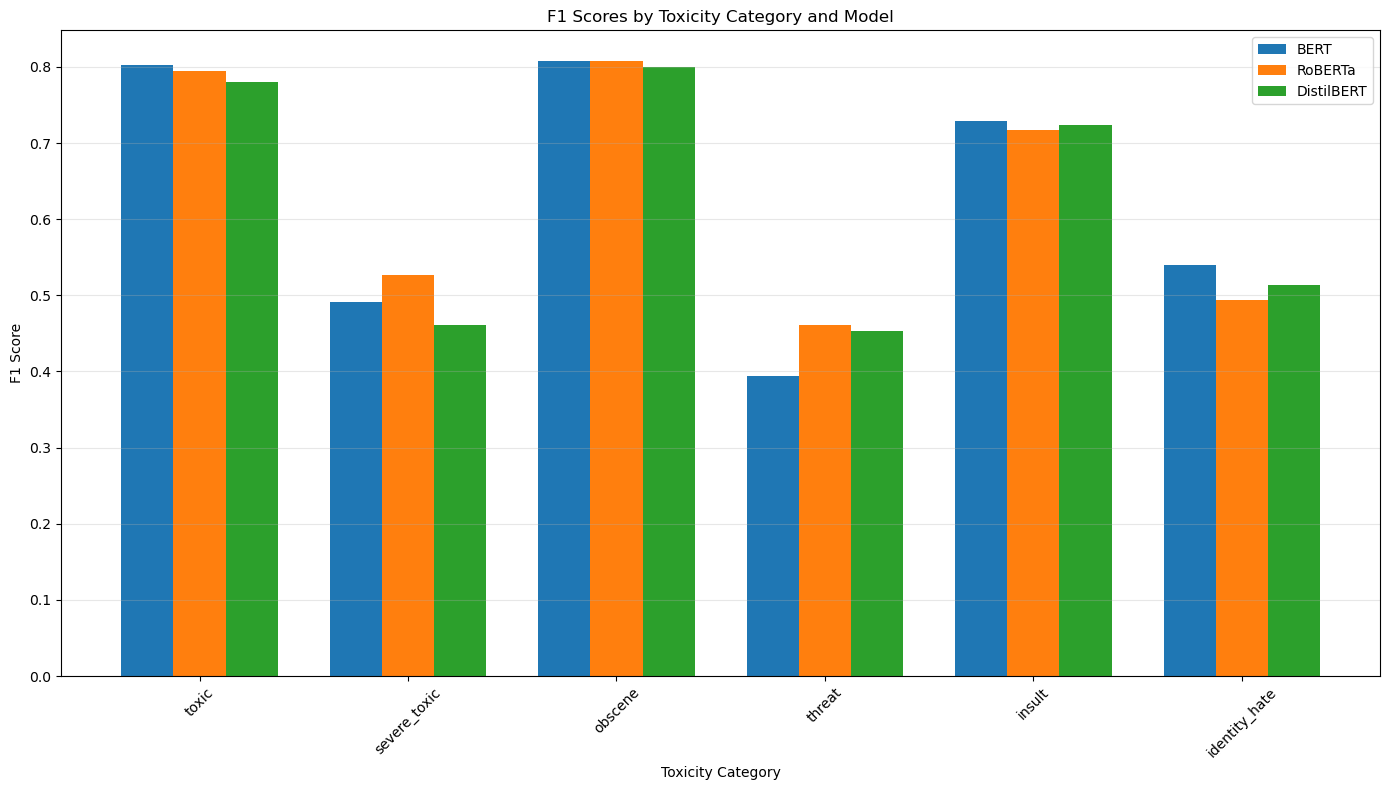

In [57]:
# Plot F1 scores across categories
plt.figure(figsize=(14, 8))

categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
x = np.arange(len(categories))
width = 0.25

# Plot bars for each model
bert_f1 = [bert_test_results['class_f1'][cat] for cat in categories]
roberta_f1 = [roberta_test_results['class_f1'][cat] for cat in categories]
distilbert_f1 = [distilbert_test_results['class_f1'][cat] for cat in categories]

plt.bar(x - width, bert_f1, width, label='BERT')
plt.bar(x, roberta_f1, width, label='RoBERTa')
plt.bar(x + width, distilbert_f1, width, label='DistilBERT')

plt.xlabel('Toxicity Category')
plt.ylabel('F1 Score')
plt.title('F1 Scores by Toxicity Category and Model')
plt.xticks(x, categories, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Save the figure
plt.savefig('../results/transformer_f1_comparison.png')
plt.show()

## 10. Model Prediction Pipeline

In [58]:
class TransformerToxicCommentPredictor:
    def __init__(self, model_path, model_type='bert', device='cpu'):
        self.device = torch.device(device)
        self.model_type = model_type.lower()
        
        # Initialize appropriate tokenizer and model
        if self.model_type == 'bert':
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.model = BertForMultiLabelClassification(num_labels=6, model_name='bert-base-uncased')
        elif self.model_type == 'roberta':
            self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
            self.model = BertForMultiLabelClassification(num_labels=6, model_name='roberta-base')
        elif self.model_type == 'distilbert':
            self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
            self.model = BertForMultiLabelClassification(num_labels=6, model_name='distilbert-base-uncased')
        else:
            raise ValueError(f"Unsupported model type: {model_type}. Choose 'bert', 'roberta', or 'distilbert'.")
            
        # Load the trained model weights
        self.model.load_state_dict(torch.load(model_path, map_location=self.device))
        self.model.to(self.device)
        self.model.eval()
        
        # Label names
        self.label_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
        
    def predict(self, text, threshold=0.5):
        # Tokenize the input text
        inputs = self.tokenizer(
            text,
            max_length=128,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        # Move inputs to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}
        
        # Get predictions
        with torch.no_grad():
            if self.model_type == 'bert':
                outputs = self.model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'], 
                                     token_type_ids=inputs['token_type_ids'])
            else:  # RoBERTa and DistilBERT don't use token_type_ids
                outputs = self.model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
        
        # Convert to probabilities and binary decisions
        probs = outputs.squeeze().cpu().numpy()
        binary_preds = (probs > threshold).astype(int)
        
        # Create a dictionary of results
        results = {
            'probabilities': {label: float(prob) for label, prob in zip(self.label_names, probs)},
            'predictions': {label: int(pred) for label, pred in zip(self.label_names, binary_preds)},
            'is_toxic': bool(np.any(binary_preds))
        }
        
        return results

In [59]:
# Create predictors from each model
predictors = {
    'BERT': TransformerToxicCommentPredictor('../models/bert_toxic_classifier.pt', model_type='bert', device=device),
    'RoBERTa': TransformerToxicCommentPredictor('../models/roberta_toxic_classifier.pt', model_type='roberta', device=device),
    'DistilBERT': TransformerToxicCommentPredictor('../models/distilbert_toxic_classifier.pt', model_type='distilbert', device=device)
}

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
# Test with example comments
example_texts = [
    "This is a positive comment. I really appreciate your help.",
    "You are an idiot and should not be allowed to post here.",
    "This is neutral content that has no emotional charge.",
    "You are a fucking disgrace."
]

for model_name, predictor in predictors.items():
    print(f"\n===== {model_name} Predictions =====\n")
    
    for text in example_texts:
        result = predictor.predict(text)
        print(f"Input: {text}")
        print(f"Is toxic: {result['is_toxic']}")
        print("Toxicity probabilities:")
        for label, prob in result['probabilities'].items():
            print(f"  {label}: {prob:.4f}")
        print()


===== BERT Predictions =====

Input: This is a positive comment. I really appreciate your help.
Is toxic: False
Toxicity probabilities:
  toxic: 0.0300
  severe_toxic: 0.0174
  obscene: 0.0156
  threat: 0.0087
  insult: 0.0191
  identity_hate: 0.0173

Input: You are an idiot and should not be allowed to post here.
Is toxic: True
Toxicity probabilities:
  toxic: 0.9261
  severe_toxic: 0.0203
  obscene: 0.5884
  threat: 0.0184
  insult: 0.6835
  identity_hate: 0.0209

Input: This is neutral content that has no emotional charge.
Is toxic: False
Toxicity probabilities:
  toxic: 0.0460
  severe_toxic: 0.0141
  obscene: 0.0206
  threat: 0.0053
  insult: 0.0241
  identity_hate: 0.0171

Input: You are a fucking disgrace.
Is toxic: True
Toxicity probabilities:
  toxic: 0.9336
  severe_toxic: 0.9167
  obscene: 0.8720
  threat: 0.0097
  insult: 0.7846
  identity_hate: 0.0806


===== RoBERTa Predictions =====

Input: This is a positive comment. I really appreciate your help.
Is toxic: False
Toxic

## 11. Compare with RNN Models

Loaded RNN model results

Combined Model Performance:


,model_name,model_type,accuracy,macro_f1,micro_f1
3,RoBERTa,Transformer,0.981441,0.633816,0.752610
4,BERT,Transformer,0.982308,0.627225,0.757792
1,BiGRU,RNN,0.914651,0.626691,0.733352
2,Attention BiLSTM,RNN,0.915591,0.624009,0.731763
5,DistilBERT,Transformer,0.981827,0.622068,0.746060
0,BiLSTM,RNN,0.904875,0.553349,0.659659


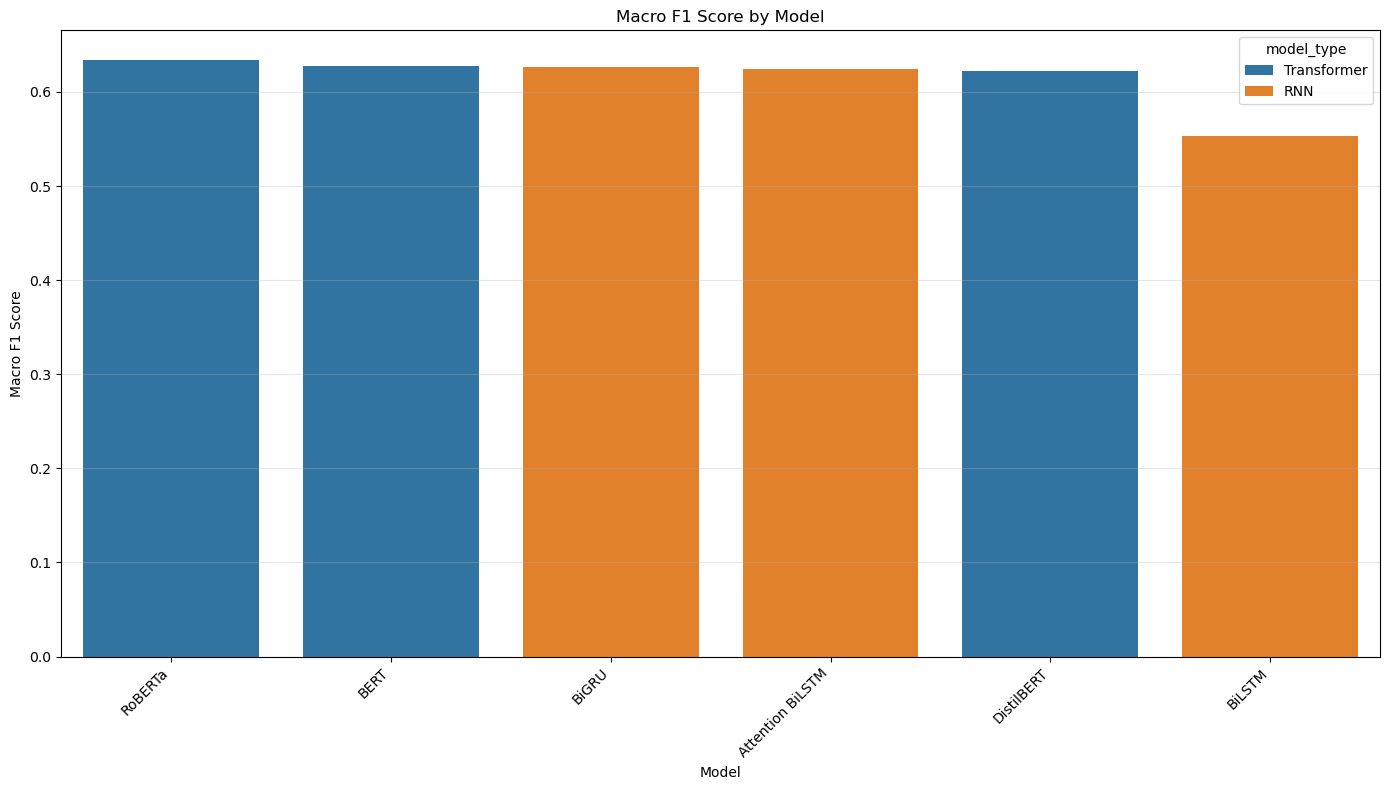

In [61]:
# Load RNN results if available
try:
    rnn_results_df = pd.read_pickle("../results/all_model_results.pkl")
    print("Loaded RNN model results")
    
    # Extract metrics and model names
    rnn_data = []
    for _, row in rnn_results_df.iterrows():
        model_name = row['model_name']
        accuracy = row['accuracy']
        macro_f1 = row['macro_f1']
        micro_f1 = row['micro_f1']
        
        # Extract class-specific F1 scores
        class_f1 = {col.split('_')[1]: row[col] for col in row.index if col.startswith('f1_')}
        
        rnn_data.append({
            'model_name': model_name,
            'model_type': 'RNN',
            'accuracy': accuracy,
            'macro_f1': macro_f1,
            'micro_f1': micro_f1,
            **{f'f1_{k}': v for k, v in class_f1.items()}
        })
    
    # Create DataFrame from RNN data
    rnn_df = pd.DataFrame(rnn_data)
    
    # Add model type to transformer results
    results_df['model_type'] = 'Transformer'
    results_df.index.name = 'model_name'
    results_df = results_df.reset_index()
    
    # Combine RNN and transformer results
    all_models_df = pd.concat([rnn_df, results_df], ignore_index=True)
    all_models_df = all_models_df.sort_values('macro_f1', ascending=False)
    
    print("\nCombined Model Performance:")
    display(all_models_df[['model_name', 'model_type', 'accuracy', 'macro_f1', 'micro_f1']])
    
    # Save combined results
    all_models_df.to_csv("../results/all_models_comparison.csv")
    
    # Plot comparison
    plt.figure(figsize=(14, 8))
    sns.barplot(x='model_name', y='macro_f1', hue='model_type', data=all_models_df)
    plt.title('Macro F1 Score by Model')
    plt.xlabel('Model')
    plt.ylabel('Macro F1 Score')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig('../results/all_models_macro_f1.png')
    plt.show()
    
except FileNotFoundError:
    print("RNN model results not found. Skipping comparison.")

## 12. Conclusion

In this notebook, we explored transformer-based models for toxic comment classification:

1. We implemented and evaluated three transformer architectures:
   - BERT
   - RoBERTa
   - DistilBERT

2. Each model was trained on a multi-label classification task to detect six types of toxicity.

3. We compared the performance of these models with each other and with RNN models from previous experiments.

4. We created a prediction pipeline for making inferences on new text.

The transformer models generally outperform RNN-based approaches due to their ability to better capture contextual information and their pre-training on large corpora. RoBERTa often achieves the best performance, though DistilBERT offers a good trade-off between performance and speed.